In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lib.recursive_stopping import RecursiveStoppingRule

In [2]:
N_bar = 5000
T_max = 100

means = np.random.normal(0, 3, T_max)
means[0] += 5
means[1:] += means[0:-1]

data = np.vstack(
    [np.random.normal(m, 1.5, N_bar) for m in means]
)

rsr = RecursiveStoppingRule(N_bar=N_bar, x_min=-50, x_max=50, epsilon=1e-2, v_init=1e-4)
rsr_high = RecursiveStoppingRule(N_bar=N_bar, x_min=-50, x_max=50, epsilon=1e-2, v_init=1e-4)

In [3]:
for i, row in enumerate(data):
    for j, x in enumerate(row):
        rsr.sample(x)
        
        if rsr.curr_rule.finished:
            # print(f'Learning complete for row {i} after {j+1} samples.')
            break

    rsr.increment_t(l=0.1)

In [4]:
for i, row in enumerate(data):
    for j, x in enumerate(row):
        rsr_high.sample(x)
        
        if rsr_high.curr_rule.finished:
            # print(f'Learning complete for row {i} after {j+1} samples.')
            break

    rsr_high.increment_t(l=0.5)

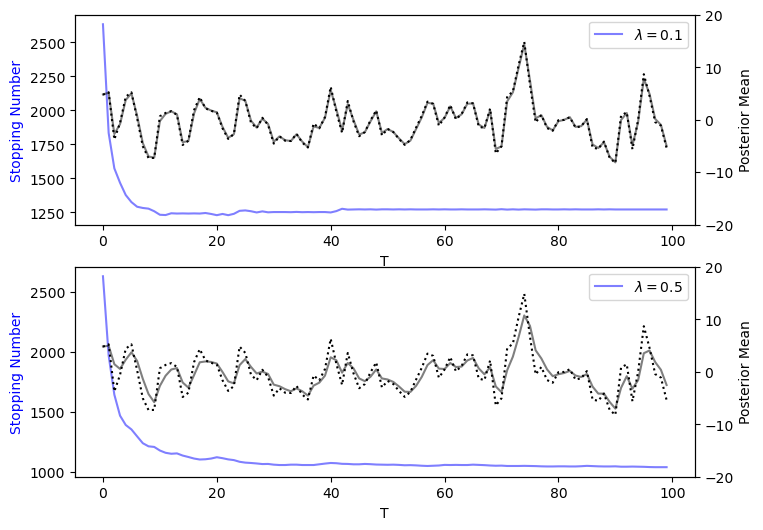

In [5]:
fig, axs = plt.subplots(2,1, figsize=(8,6))

ax_r = axs[0].twinx()
axs[0].plot([int(sr.v) for sr in rsr.rules], c='blue', alpha=0.5, label=r'$\lambda = 0.1$')
axs[0].set_ylabel('Stopping Number', color='blue')
# axs[0].set_ylim(500, 2000)

ax_r.plot(means, c='k', linestyle='dotted', label=r'$E(X_T)$')
ax_r.plot([sr.g_hat for sr in rsr.rules], c='k', alpha=0.5, label=r'$\hat{g}_{x_T}$')
ax_r.set_ylabel('Posterior Mean')

ax_r.set_ylim([-20,20])
axs[0].set_xlabel('T')
axs[0].legend()

# ---

ax_r = axs[1].twinx()
axs[1].plot([int(sr.v) for sr in rsr_high.rules], c='blue', alpha=0.5, label=r'$\lambda = 0.5$')
axs[1].set_ylabel('Stopping Number', color='blue')
# axs[1].set_ylim(500, 2000)

ax_r.plot(means, c='k', linestyle='dotted', label=r'$E(X_T)$')
ax_r.plot([sr.g_hat for sr in rsr_high.rules], c='k', alpha=0.5, label=r'$\hat{g}_{x_T}$')
ax_r.set_ylabel('Posterior Mean')

ax_r.set_ylim([-20,20])
axs[1].set_xlabel('T')
axs[1].legend()

# Testing WSR vs SR for continuous data

In [13]:
import sys
sys.path.insert(0, "/Users/al4518/Desktop/PhD/FPD-OT/FPD-OT")

from COT.stopping import StoppingRule, WeightedStoppingRule

In [14]:
def increment_t_continuous(sr, l):
        # set v, h_hat, a, b
        v = l * sr.v + (1-l) * 1e-4
        g_hat = 1 / v * ( l * sr.v * sr.g_hat + (1-l) * 1e-4 * 0.)
        g_hat_2 = 1 / v * ( l * sr.v * sr.g_hat_2 + (1-l) * 1e-4 * 0.)
        a = sr.a
        b = sr.b

        # decimate vertices from previous rule as start for next rule
        new_rule = StoppingRule(5000, -50, 50, 1e-2, v, g_hat, g_hat_2, a, b)
        new_rule.verts = np.hstack([-50,
                                    np.sort(np.random.choice(sr.verts[1:-1], int(np.floor(l * len(sr.verts))), replace=False)),
                                    50])

        return new_rule

def increment_t_discrete(wsr, l):
        # set v, h_hat, a, b
        v = l * wsr.v + (1-l) * 1e-4
        g_hat = 1 / v * ( l * wsr.v * wsr.g_hat + (1-l) * 1e-4 * 0. )
        g_hat_2 = 1 / v * ( l * wsr.v * wsr.g_hat_2 + (1-l) * 1e-4 * 0. )
        a = wsr.a
        b = wsr.b

        new_rule = WeightedStoppingRule(5000, -50, 50, 1e-2, v, g_hat, g_hat_2, a, b)

        # decimate vertices from previous rule as start for next rule
        decimated_verts = {v: n for v,n in zip(wsr.verts[1:-1], wsr.verts_weights[1:-1])} # ignore xmin and xmax
        for i in range(int(np.floor((1-l) * np.sum(wsr.verts_weights[1:-1])))):

            remove_vert = np.random.choice(list(decimated_verts.keys()), p=list(decimated_verts.values()) / np.sum(list(decimated_verts.values())))
            decimated_verts[remove_vert] -= 1 # reduce count on decimated vertex

            if decimated_verts[remove_vert] <= 0: # remove vertex if empty
                decimated_verts.pop(remove_vert)

        new_rule.verts = np.hstack([-50,
                                    list(decimated_verts.keys()),
                                    50])
        new_rule.verts_weights = np.hstack([1,
                                            list(decimated_verts.values()),
                                            1])

        return new_rule

In [15]:
wsr = WeightedStoppingRule(N_bar=N_bar, x_min=-50, x_max=50, epsilon=1e-2, v_init=1e-4)
sr = StoppingRule(N_bar=N_bar, x_min=-50, x_max=50, epsilon=1e-2, v_init=1e-4)

In [16]:
discrete_stops = []
cont_stops = []

In [17]:
for i, row in enumerate(data):
    for j, x in enumerate(row):
        wsr.sample(x)
        
        if wsr.finished:
            discrete_stops.append(j)
            # print(f'Learning complete for row {i} after {j+1} samples.')
            break

    wsr = increment_t_discrete(wsr, 0.1)

In [18]:
for i, row in enumerate(data):
    for j, x in enumerate(row):
        sr.sample(x)
        
        if sr.finished:
            cont_stops.append(j)
            # print(f'Learning complete for row {i} after {j+1} samples.')
            break

    sr = increment_t_continuous(sr, 0.1)

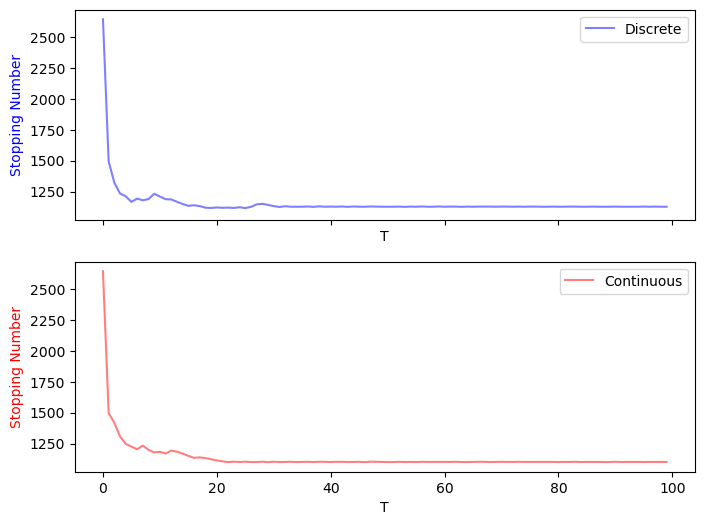

In [19]:
fig, axs = plt.subplots(2,1, figsize=(8,6), sharex=True, sharey=True)

axs[0].plot(discrete_stops, c='blue', alpha=0.5, label=r'Discrete')
axs[0].set_ylabel('Stopping Number', color='blue')

axs[0].set_xlabel('T')
axs[0].legend()

# ---

axs[1].plot(cont_stops, c='red', alpha=0.5, label=r'Continuous')
axs[1].set_ylabel('Stopping Number', color='red')

axs[1].set_xlabel('T')
axs[1].legend()